## Логистическая регрессия

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

import warnings
warnings.filterwarnings("ignore")

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

In [2]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.01, max_epoch=10, penalty='l2', print_loss=False):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
        self.print_loss = print_loss
        self.losses = []
        
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def loss(self, X, y=None):
        self.fit(X, y)
        z = np.dot(X, self.theta)
        h = self.__sigmoid(z)
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        X = np.array(X)
        intercept = np.ones((X.shape[0], 1))
        X = np.concatenate((intercept, X), axis=1)
        self.theta = np.ones(X.shape[1])
        m = len(X)
        for epoch in range(self.max_epoch):
            p = np.random.permutation(m)
            for i in p:
                random_index = np.random.randint(m)
                xi = X[i]
                yi = y[i]
                z = np.dot(X, self.theta)
                h = self.__sigmoid(z)
                gradients = 1/m *(np.dot(X.T, (h - y)))
                if self.penalty=='l2':
                    gradients += 2*self.C*self.theta
                elif self.penalty=='l1':
                    gradients += self.C*np.sign(self.theta)
                old_theta = self.theta
                self.theta = self.theta-self.alpha*gradients
                if np.linalg.norm(self.theta-old_theta) < 0.0001:
                    break
            
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            self.loss = (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean() 
            self.losses.append(self.loss)
            if self.print_loss == True:
                print('Epoch :'+str(epoch)+'. Loss: '+str(self.loss))
        return self
    
    def partial_fit(self, X, y=None):
        '''
        По желанию - метод дообучения модели на новых данных
        '''
    
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''
        arr = []
        for i in X:
            if self.predict_proba(X) >= 0.5:
                return 1
            else:
                return 0
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        X = np.array(X)
        intercept = np.ones((X.shape[0], 1))
        X = np.concatenate((intercept, X), axis=1)
        z = np.dot(X, self.theta)
        y_hat_proba = self.__sigmoid(z)
        
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

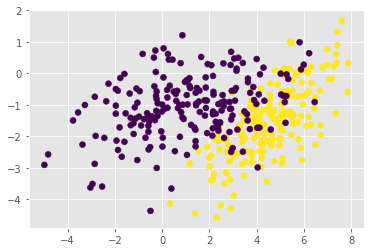

In [3]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

plt.scatter(X[:,0], X[:,1], c=y)

In [4]:
model = MySGDClassifier(alpha=0.01, penalty=None, max_epoch=20, print_loss=True)
model.fit(X, y)

Epoch :0. Loss: 0.6612350569897483
Epoch :1. Loss: 0.5719928238092813
Epoch :2. Loss: 0.5135266402109362
Epoch :3. Loss: 0.4718574080434644
Epoch :4. Loss: 0.4411285445608181
Epoch :5. Loss: 0.417773658513852
Epoch :6. Loss: 0.399529015817432
Epoch :7. Loss: 0.3849313266062114
Epoch :8. Loss: 0.3730104331458331
Epoch :9. Loss: 0.3631048642590147
Epoch :10. Loss: 0.35475112615204635
Epoch :11. Loss: 0.34761613322932206
Epoch :12. Loss: 0.34145498290451654
Epoch :13. Loss: 0.33608388651984045
Epoch :14. Loss: 0.33136237527078355
Epoch :15. Loss: 0.3271813225017921
Epoch :16. Loss: 0.3234547020980273
Epoch :17. Loss: 0.32011380206770573
Epoch :18. Loss: 0.31710308626905376
Epoch :19. Loss: 0.3143771845332387


MySGDClassifier(C=1, alpha=0.01, max_epoch=20, penalty=None, print_loss=True)

[(-5, 5), Text(0, 0.5, '$X_2$'), (-5, 5), Text(0.5, 0, '$X_1$'), None]

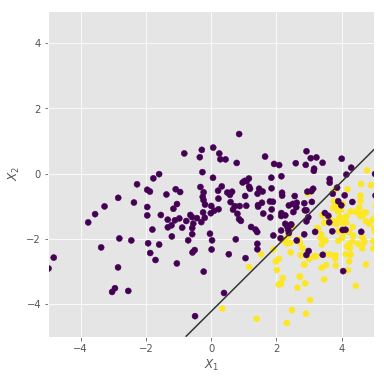

In [5]:
xx, yy = np.mgrid[-5:8, -5:2]
grid = np.c_[xx.ravel(), yy.ravel()]
probs = model.predict_proba(grid).reshape(xx.shape)
f, ax = plt.subplots(figsize=(8, 6))
ax.contour(xx, yy, probs, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

plt.scatter(X[:,0], X[:,1], c=y)
ax.set(aspect="equal",
       xlim=(-5, 5), ylim=(-5, 5),
       xlabel="$X_1$", ylabel="$X_2$")

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

In [6]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1., 10.]
losses = []
for alpha in alphas:
    m1 = MySGDClassifier(alpha=alpha, penalty=None, max_epoch=20, print_loss=False)
    m1.fit(X, y)
    losses.append(m1.loss)
losses

[1.0322818292834348,
 0.5720148431780295,
 0.3143771845332387,
 0.27264284478252326,
 0.27243669714886387,
 1.518894335284565]

In [7]:
alphas_str = [str(alpha) for alpha in alphas]

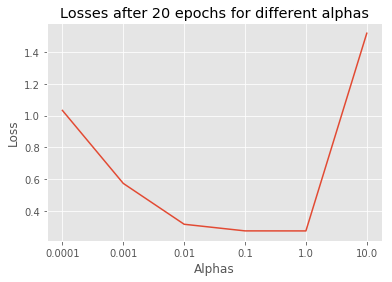

In [8]:
plt.plot(alphas_str, losses)
plt.xlabel('Alphas')
plt.ylabel('Loss')
plt.title('Losses after 20 epochs for different alphas')
plt.show()

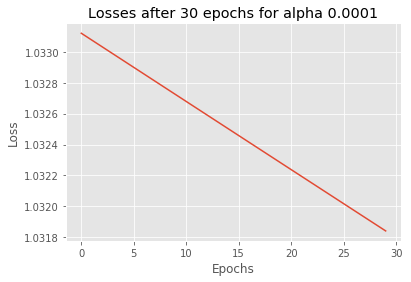

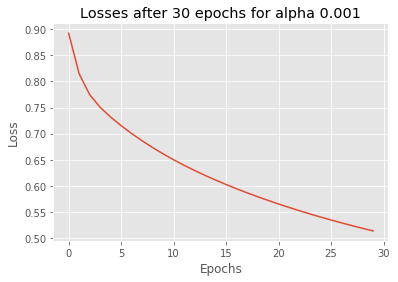

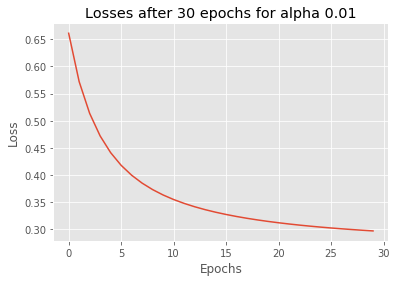

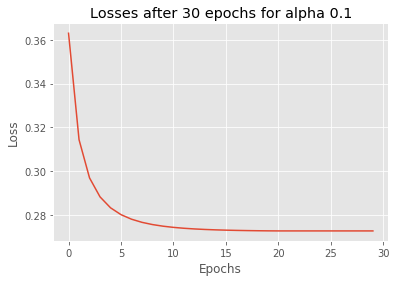

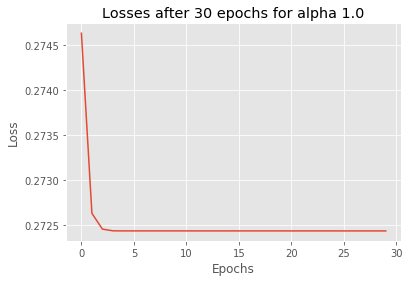

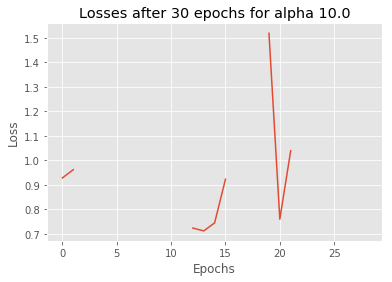

In [9]:
for alpha in alphas:
    m2 = MySGDClassifier(alpha=alpha, penalty=None, max_epoch=30, print_loss=False)
    m2.fit(X, y)
    plt.plot(m2.losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Losses after 30 epochs for alpha '+str(alpha))
    plt.show()